In [1]:
%load_ext autoreload
%autoreload 2

#from configs.RecursiveVPSDE.recursive_Markovian_PostMeanScaledScore_fSin_T256_H05_tl_5data import get_config as get_config
from configs.RecursiveVPSDE.Markovian_fSin.recursive_Markovian_PostMeanScore_fSin_T256_H05_tl_5data import get_config
#from configs.RecursiveVPSDE.recursive_Markovian_fSinWithPosition_T256_H05_tl_5data import get_config as get_config

from configs import project_config
import numpy as np
import torch
import os
from src.generative_modelling.models.ClassVPSDEDiffusion import VPSDEDiffusion
from src.generative_modelling.models.TimeDependentScoreNetworks.ClassConditionalMarkovianTSPostMeanScoreMatching  import \
    ConditionalMarkovianTSPostMeanScoreMatching
from src.generative_modelling.models.TimeDependentScoreNetworks.ClassConditionalMarkovianTSScoreMatching import ConditionalMarkovianTSScoreMatching
from src.generative_modelling.models.TimeDependentScoreNetworks.ClassConditionalLSTMTSPostMeanScoreMatching  import \
    ConditionalLSTMTSPostMeanScoreMatching
from tqdm import tqdm

import matplotlib.pyplot as plt

In [3]:
config = get_config()
print(config.beta_min)
if config.has_cuda:
    device = int(os.environ["LOCAL_RANK"])
else:
    print("Using CPU\n")
    device = torch.device("cpu")

diffusion = VPSDEDiffusion(beta_max=config.beta_max, beta_min=config.beta_min)

max_diff_steps = config.max_diff_steps
sample_eps = config.sample_eps
ts_step = config.deltaT

Nepoch = 1440#config.max_epochs[0]
# Fix the number of training epochs and training loss objective loss
if "PM" in config.scoreNet_trained_path:
    PM = ConditionalMarkovianTSPostMeanScoreMatching(*config.model_parameters).to(device)
else:
    PM = ConditionalMarkovianTSScoreMatching(*config.model_parameters).to(device)
PM.load_state_dict(torch.load(config.scoreNet_trained_path + "_NEp" + str(Nepoch)))

0.0
Using CPU



<All keys matched successfully>

In [4]:
Xshape = config.ts_length
num_taus = 20
num_diff_times = config.max_diff_steps
assert (num_diff_times * num_taus == 200000)
Ndiff_discretisation = config.max_diff_steps
diffusion_times = torch.linspace(start=config.sample_eps, end=config.end_diff_time,
                                 steps=Ndiff_discretisation).to(device)

# Create a uniform grid
x = np.linspace(-2, 2, 5)
y = np.linspace(-3, 3, 5)
z = np.linspace(0, 5, 5)

# Create a 3D mesh grid
X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
D = 3
# Combine into a single array of shape (n^3, 3) if needed
Xs = torch.Tensor(np.stack([X.ravel(), Y.ravel(), Z.ravel()], axis=-1)[np.newaxis, :, :]).to(device)
Xshape = Xs.shape[1]
B = Xs.shape[1]
T = 1
conditioner = Xs.permute(1, 0, 2)
mu_hats = np.zeros((Xshape, D, num_diff_times, num_taus))  # Xvalues, TS Dimension, DiffTimes, Ztaus
PM.eval()
for k in tqdm(range(num_taus)):
    difftime_idx = num_diff_times - 1
    Z_taus = diffusion.prior_sampling(shape=(Xshape, 1, D)).to(device)
    while difftime_idx >= 0:
        d = diffusion_times[Ndiff_discretisation - (num_diff_times - 1 - difftime_idx) - 1].to(device)
        diff_times = torch.stack([d for _ in range(B)]).reshape(B * 1, 1, -1).squeeze(-1).squeeze(-1).squeeze(-1).to(
            device)
        eff_times = torch.cat([diffusion.get_eff_times(diff_times=diff_times).unsqueeze(-1).unsqueeze(-1)] * D,
                              dim=2).to(device)
        if k == 0 and difftime_idx < 100:
            print(d)
        with torch.no_grad():
            if "PM" in config.scoreNet_trained_path:
                predicted_score = PM.forward(inputs=Z_taus, times=diff_times, conditioner=conditioner,
                                             eff_times=eff_times)
            else:
                predicted_score = PM.forward(inputs=Z_taus, times=diff_times, conditioner=conditioner)
            scores, drift, diffParam = diffusion.get_conditional_reverse_diffusion(x=Z_taus,
                                                                                   predicted_score=predicted_score,
                                                                                   diff_index=torch.Tensor(
                                                                                       [int((
                                                                                               num_diff_times - 1 - difftime_idx))]).to(
                                                                                       device),
                                                                                   max_diff_steps=Ndiff_discretisation)
        # assert np.allclose((scores- predicted_score).detach(), 0)
        beta_taus = torch.exp(-0.5 * eff_times[0, 0, 0]).to(device)
        sigma_taus = torch.pow(1. - torch.pow(beta_taus, 2), 0.5).to(device)
        for i in range(Xshape):
            Zts = Z_taus[i, :, :]
            Ss = scores[i, :, :]
            mu_hat = Zts / (ts_step * beta_taus) + (
                    (torch.pow(sigma_taus, 2) + (torch.pow(beta_taus, 2) * ts_step)) / (ts_step * beta_taus)) * Ss
            mu_hats[i, :, difftime_idx, k] = mu_hat[0, :].cpu().detach().numpy()
        z = torch.randn_like(drift).to(device)
        Z_taus = drift + diffParam * z
        difftime_idx -= 1

  0%|          | 0/20 [00:02<?, ?it/s]

KeyboardInterrupt



In [ ]:
from mpl_toolkits.mplot3d import Axes3D
numpy_Xs = Xs.numpy()[0,:,:]
print(numpy_Xs.shape, mu_hats.shape)
true_drifts = np.zeros_like(numpy_Xs)
# Create a uniform grid
x = np.linspace(-20, 20, 5)
y = np.linspace(-30, 30, 5)
z = np.linspace(0, 50, 5)
# Create a 3D mesh grid
X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
u = config.ts_sigma * (Y-X)
v = X * (config.ts_rho - Z) - Y
w = X*Y-config.ts_beta * Z
norm = np.sqrt(u**2 + v**2 + w**2)
norm = np.where(norm == 0.,1e-12 ,norm)
u /= norm
v /= norm
w /= norm
for j in range(0, num_diff_times, 2000):
    mhats = np.mean(mu_hats[:,:,9000:,:].reshape((mu_hats.shape[0], mu_hats.shape[1], (mu_hats.shape[2]-9000)*mu_hats.shape[-1])), axis=2)
    grid_size = (5,5,5)
    uhat = mhats[:, 0].reshape(grid_size)  # (5, 5, 5)
    vhat = mhats[:, 1].reshape(grid_size)  # (5, 5, 5)
    what = mhats[:, 2].reshape(grid_size)  # (5, 5, 5)
    norm = np.sqrt(uhat**2 + vhat**2 + what**2)
    norm = np.where(norm == 0.,1e-12 ,norm)
    uhat /= norm
    vhat /= norm
    what /= norm
    # Plot the quiver
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.quiver(X, Y, Z, u, v, w, length=2, color='blue')
    ax.quiver(X, Y, Z, uhat, vhat, what, length=2, color='red')
    plt.show()
    plt.close()
    break



In [4]:
"""Xshape = config.ts_length
num_taus = 20
num_diff_times = 1000
Ndiff_discretisation = num_diff_times  #config.max_diff_steps
diffusion_times = torch.linspace(start=config.sample_eps, end=config.end_diff_time,
                                 steps=Ndiff_discretisation).to(device)
mu_hats_mean = np.zeros((Xshape, num_taus))
mu_hats_std = np.zeros((Xshape, num_taus))

Xs = torch.linspace(-2, 2, steps=Xshape).unsqueeze(-1).unsqueeze(-1).permute(1,0,2)
conditioner = torch.stack([Xs for _ in range(1)], dim=0).reshape(Xshape*1, 1, -1)
B, T = Xshape, 1
mu_hats = np.zeros((Xshape, num_diff_times, num_taus))  # Xvalues, DiffTimes, Ztaus
PM.eval()
for k in tqdm(range(num_taus)):
    difftime_idx = num_diff_times - 1
    Z_taus = diffusion.prior_sampling(shape=(Xshape, 1, 1))
    while difftime_idx >= 0:
        d = diffusion_times[Ndiff_discretisation-(num_diff_times - 1 - difftime_idx)-1]
        diff_times = torch.stack([d for _ in range(B)]).reshape(B*T, 1, -1).squeeze(-1).squeeze(-1).squeeze(-1)
        eff_times = diffusion.get_eff_times(diff_times=diff_times).unsqueeze(-1).unsqueeze(-1)
        if k == 0 and difftime_idx < 100:
            print(d)
        with torch.no_grad():
            if "PM" in config.scoreNet_trained_path:
                predicted_score = PM.forward(inputs=Z_taus, times=diff_times, conditioner=conditioner, eff_times=eff_times)
            else:
                predicted_score = PM.forward(inputs=Z_taus, times=diff_times, conditioner=conditioner)
            scores, drift, diffParam = diffusion.get_conditional_reverse_diffusion(x=Z_taus,
                                                                                      predicted_score=predicted_score,
                                                                                      diff_index=torch.Tensor(
                                                                                          [int((num_diff_times - 1 - difftime_idx))]).to(device),
                                                                                      max_diff_steps=Ndiff_discretisation)
        #assert np.allclose((scores- predicted_score).detach(), 0)
        beta_taus = torch.exp(-0.5 * eff_times[0,0,0])
        sigma_taus = torch.pow(1. - torch.pow(beta_taus, 2), 0.5)
        for i in range(Xshape):
            Zts = Z_taus[i, :,:]
            Ss = scores[i,:,:]
            mu_hat = Zts/(ts_step*beta_taus) + ((torch.pow(sigma_taus, 2)+(torch.pow(beta_taus,2)*ts_step))/(ts_step*beta_taus))*Ss
            mu_hats[i, difftime_idx, k] = mu_hat[0,0]
        z = torch.randn_like(drift)
        Z_taus = drift + diffParam * z
        difftime_idx -= 1"""

'Xshape = config.ts_length\nnum_taus = 20\nnum_diff_times = 1000\nNdiff_discretisation = num_diff_times  #config.max_diff_steps\ndiffusion_times = torch.linspace(start=config.sample_eps, end=config.end_diff_time,\n                                 steps=Ndiff_discretisation).to(device)\nmu_hats_mean = np.zeros((Xshape, num_taus))\nmu_hats_std = np.zeros((Xshape, num_taus))\n\nXs = torch.linspace(-2, 2, steps=Xshape).unsqueeze(-1).unsqueeze(-1).permute(1,0,2)\nconditioner = torch.stack([Xs for _ in range(1)], dim=0).reshape(Xshape*1, 1, -1)\nB, T = Xshape, 1\nmu_hats = np.zeros((Xshape, num_diff_times, num_taus))  # Xvalues, DiffTimes, Ztaus\nPM.eval()\nfor k in tqdm(range(num_taus)):\n    difftime_idx = num_diff_times - 1\n    Z_taus = diffusion.prior_sampling(shape=(Xshape, 1, 1))\n    while difftime_idx >= 0:\n        d = diffusion_times[Ndiff_discretisation-(num_diff_times - 1 - difftime_idx)-1]\n        diff_times = torch.stack([d for _ in range(B)]).reshape(B*T, 1, -1).squeeze(-1).

In [5]:
"""diffusion_times = torch.linspace(start=config.sample_eps, end=config.end_diff_time,
                                 steps=config.max_diff_steps).to(device)
Xshape = config.ts_length
num_taus = 1
num_diff_times = 10
mu_hats_mean = np.zeros((Xshape, num_taus))
mu_hats_std = np.zeros((Xshape, num_taus))

#inc_Xs = torch.concat([torch.randn(1)*np.sqrt(ts_step) for _ in range(Xshape)]).unsqueeze(-1).unsqueeze(-1).permute(1,0,2)
#Xs = torch.cat([torch.zeros((inc_Xs.shape[0], 1, inc_Xs.shape[-1])).to(device), inc_Xs], dim=1)
#Xs = torch.cumsum(Xs, dim=1)


#inc_Xs = torch.concat([torch.randn(1)*np.sqrt(ts_step) for _ in range(Xshape)]).unsqueeze(-1).unsqueeze(-1).permute(1,0,2)
#Xs = torch.cat([torch.zeros((inc_Xs.shape[0], 1, inc_Xs.shape[-1])).to(device), inc_Xs], dim=1)
#Xs = torch.cumsum(Xs, dim=1)

Xs = torch.linspace(-2, 2, steps=Xshape).unsqueeze(-1).unsqueeze(-1).permute(1,0,2)
#conditioner = torch.stack([PM.rnn(Xs[:, i, :], None)[0] for i in range(Xs.shape[1])], dim=1)
conditioner = torch.stack([Xs for _ in range(1)], dim=0).reshape(Xshape*1, 1, -1)
num_incs = 10
B, T = Xshape, 1
mu_hats = np.zeros((Xshape, num_incs, num_diff_times, num_taus))  # Xvalues, DiffTimes, Ztaus
for inc_idx in range(num_incs):
    inc_Xs = torch.concat([np.sqrt(ts_step)+torch.randn(1)*np.sqrt(ts_step) for _ in range(Xshape)]).unsqueeze(-1).unsqueeze(-1).permute(1,0,2)
    difftime_idx = 0
    for j in tqdm(range(0, config.max_diff_steps, np.floor(config.max_diff_steps/num_diff_times).astype(int))):
        d = diffusion_times[j]
        diff_times = d+0*torch.linspace(start=config.sample_eps, end=config.end_diff_time,
                                             steps=config.max_diff_steps).to(device)[-1:]
        eff_times = diffusion.get_eff_times(diff_times=diff_times).unsqueeze(-1).unsqueeze(-1)
        beta_taus = torch.exp(-0.5 * eff_times)
        sigma_taus = torch.pow(1. - torch.pow(beta_taus, 2), 0.5)
        diff_times = torch.stack([diff_times for _ in range(B)]).reshape(B*T, 1, -1).squeeze(-1).squeeze(-1).squeeze(-1)
        eff_times = torch.stack([eff_times for _ in range(B)]).reshape(B*T, 1, -1)
        for k in range(num_taus):
            Z_taus = torch.stack([(inc_Xs * beta_taus[0,0,0]) + (torch.randn_like(inc_Xs) * sigma_taus[0,0,0]) for _ in range(1)], dim=2).squeeze(-1).permute(1,2,0)
            Z_taus = Z_taus.reshape(np.prod(Z_taus.shape), 1, 1)
            scores = PM.forward(inputs=Z_taus, times=diff_times, conditioner=conditioner, eff_times=eff_times)
            for i in range(Xshape):
                Zts = Z_taus[i, :,:]
                Ss = scores[i,:,:]
                mu_hat = Zts/(ts_step*beta_taus) + ((torch.pow(sigma_taus, 2)+(torch.pow(beta_taus,2)*ts_step))/(ts_step*beta_taus))*Ss
                mu_hats[i, inc_idx, difftime_idx, k] = mu_hat[0,0,0]
        del Zts, Ss, eff_times, diff_times, Z_taus, scores
        difftime_idx += 1"""

'diffusion_times = torch.linspace(start=config.sample_eps, end=config.end_diff_time,\n                                 steps=config.max_diff_steps).to(device)\nXshape = config.ts_length\nnum_taus = 1\nnum_diff_times = 10\nmu_hats_mean = np.zeros((Xshape, num_taus))\nmu_hats_std = np.zeros((Xshape, num_taus))\n\n#inc_Xs = torch.concat([torch.randn(1)*np.sqrt(ts_step) for _ in range(Xshape)]).unsqueeze(-1).unsqueeze(-1).permute(1,0,2)\n#Xs = torch.cat([torch.zeros((inc_Xs.shape[0], 1, inc_Xs.shape[-1])).to(device), inc_Xs], dim=1)\n#Xs = torch.cumsum(Xs, dim=1)\n\n\n#inc_Xs = torch.concat([torch.randn(1)*np.sqrt(ts_step) for _ in range(Xshape)]).unsqueeze(-1).unsqueeze(-1).permute(1,0,2)\n#Xs = torch.cat([torch.zeros((inc_Xs.shape[0], 1, inc_Xs.shape[-1])).to(device), inc_Xs], dim=1)\n#Xs = torch.cumsum(Xs, dim=1)\n\nXs = torch.linspace(-2, 2, steps=Xshape).unsqueeze(-1).unsqueeze(-1).permute(1,0,2)\n#conditioner = torch.stack([PM.rnn(Xs[:, i, :], None)[0] for i in range(Xs.shape[1])], d

In [24]:
def plot_drift_estimator(mean, stds, numpy_Xs, type, toSave:bool = True):
    fig, ax = plt.subplots(figsize=(14,9))
    rmse = np.power(np.mean(np.power(np.sin(numpy_Xs) - mean, 2)), 0.5)
    ax.scatter(numpy_Xs, np.sin(numpy_Xs), color="red", label="True Drift")

    ax.errorbar(numpy_Xs, mean, fmt="o",yerr=2*stds, label="Drift Estimator with 2 Std")
    ax.set_title(rf"RMSE {round(rmse,3)} of estimator $\bar{{\mu}}(x)$", fontsize=20)
    ax.tick_params("x",labelsize=18)
    ax.tick_params("y",labelsize=18)
    ax.set_xlabel("State $x$", fontsize=18)
    ax.set_ylabel("Drift Value", fontsize=18)
    ax.legend(loc="lower right", fontsize=18)
    if toSave:
        plt.savefig(f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/fSin_{type}.png")
    plt.show()
    plt.close()

In [25]:
print(Xs.shape)
try:
    numpy_Xs = Xs.numpy().flatten()
    #numpy_Xs = Xs[:,int(0.4*Xshape):int(0.6*Xshape)+1,:][:,:-1,:].numpy().flatten()
    #mu_hats = mu_hats[int(0.4*Xshape):int(0.6*Xshape),:,:]
except (IndexError, AttributeError) as e:
    print(e)
    assert (numpy_Xs.shape[1] == Xshape)
    pass

if "PMS" in config.scoreNet_trained_path:
    type="PMS"
elif "PM" in config.scoreNet_trained_path:
    type = "PM"
else:
    type = "Standard"
print(type)

torch.Size([1, 256, 1])
Standard


In [ ]:
for j in range(0, num_diff_times, 10):
    mhats = mu_hats[:,j,:]
    mhats = mhats.reshape(mhats.shape[0], np.prod(mhats.shape[1:]))
    mean = mhats.mean(axis=-1)
    stds = mhats.std(axis=-1)
    plot_drift_estimator(mean, stds, numpy_Xs, type=type, toSave=False)

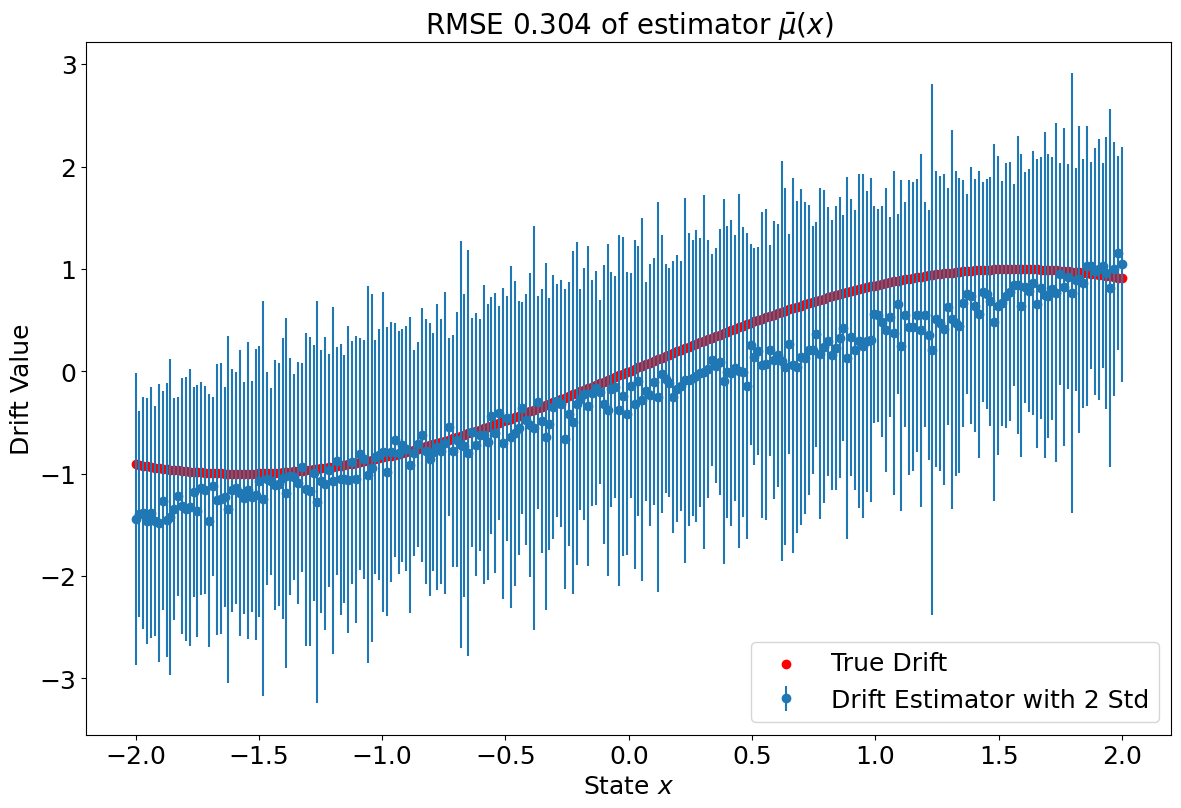

In [34]:
mean = np.array([mu_hats[i,10:200,:].flatten().mean(axis=-1) for i in range(Xshape)])
stds = np.array([mu_hats[i,10:200,:].flatten().std(axis=-1) for i in range(Xshape)])
plot_drift_estimator(mean, stds, numpy_Xs, type=type, toSave=False)